# Model Evaluation for House Price Prediction

This notebook runs the full evaluation pipeline for the trained house price prediction model and explains each step.

## Table of Contents
- [1. Setup](#1-setup)
- [2. Load Model and Data](#2-load-model-and-data)
- [3. Cross-Validation](#3-cross-validation)
- [4. Test Set Performance](#4-test-set-performance)
- [5. Feature Importance](#5-feature-importance)
- [6. Generalization on Unseen Data](#6-generalization-on-unseen-data)
- [7. Visualizations](#7-visualizations)
- [8. Evaluation Report](#8-evaluation-report)



## 1. Setup

This section installs/imports dependencies and sets up plotting defaults. If running in a clean environment, ensure dependencies are installed via `uv sync`.

- Uses the existing `tools/evaluate_model.py` to avoid duplication
- Saves figures and report in `evaluation_results/`



In [1]:
# If running in a fresh kernel, uncomment to ensure local package resolution
# import sys, os
# sys.path.append(os.path.abspath('..'))  # allow imports from project root

%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

# Ensure working directory is project root if notebook opened from notebooks/
project_root = Path('..').resolve()
os.chdir(project_root)
print(f"Working directory set to: {Path.cwd()}")

# Confirm expected files
for p in [
    Path('model/model.pkl'),
    Path('model/model_features.json'),
    Path('data/kc_house_data.csv'),
    Path('data/zipcode_demographics.csv'),
    Path('data/future_unseen_examples.csv'),
    Path('tools/evaluate_model.py'),
]:
    print(('✅' if p.exists() else '❌'), p)



Working directory set to: /home/kelee/code/gitea-local/mle-project-challenge-2
✅ model/model.pkl
✅ model/model_features.json
✅ data/kc_house_data.csv
✅ data/zipcode_demographics.csv
✅ data/future_unseen_examples.csv
✅ tools/evaluate_model.py


## 2. Load Model and Data

We instantiate the `ModelEvaluator` and load the trained model along with the prepared dataset. The loader ensures `zipcode` is treated as a 5-digit string and merges demographics by ZIP.



In [2]:
from tools.evaluate_model import ModelEvaluator

evaluator = ModelEvaluator()
loaded = evaluator.load_model_and_data()
print('Loaded:', loaded)

if not loaded:
    raise RuntimeError('Model or data not found. Run create_model.py first.')


📊 Loading model and data...
✅ Model loaded successfully
   Features: 33
   Model type: Pipeline
✅ Data loaded successfully
   Training set: 17290 samples
   Test set: 4323 samples
   Total features: 33
Loaded: True


## 3. Cross-Validation

We run 5-fold cross-validation and compute RMSE per fold, along with mean and standard deviation.



In [3]:
evaluator.evaluate_cross_validation()
print(evaluator.results.get('cv_rmse_scores'))




🔄 Performing cross-validation...
✅ Cross-validation completed
   Mean RMSE: $179,385.81
   Std RMSE: $11,611.58
   CV scores: [198374.09971004512, 175631.99077494311, 180312.70471244262, 180471.45873846387, 162138.78436303022]
[198374.09971004512, 175631.99077494311, 180312.70471244262, 180471.45873846387, 162138.78436303022]


## 4. Test Set Performance

We evaluate the model on a held-out test set and compute RMSE, MAE, R², and MAPE. A predicted-vs-actual scatter plot is also produced later in the Visualizations section.



In [4]:
evaluator.evaluate_test_set_performance()
metrics = evaluator.results.get('test_metrics', {})
metrics



📈 Evaluating test set performance...
✅ Test set evaluation completed
   RMSE: $202,626.65
   MAE: $102,339.24
   R²: 0.7284
   MAPE: 17.76%


{'mse': 41057559670.69225,
 'rmse': np.float64(202626.6509388443),
 'mae': 102339.2434883183,
 'r2': 0.7284134635701465,
 'mape': np.float64(17.763381318416506)}

## 5. Feature Importance

For this model we use correlations with the target as a proxy for feature importance. We list the top 10 strongest absolute correlations.



In [5]:
evaluator.analyze_feature_importance()
# Show top 10
import pandas as pd
correlations = pd.Series(evaluator.results.get('feature_correlations', {}))
correlations.head(10)



🔍 Analyzing feature importance...
✅ Feature importance analysis completed
   Top 10 features by correlation with price:
    1. sqft_living         : 0.7020
    2. sqft_above          : 0.6056
    3. hous_val_amt        : 0.5797
    4. medn_incm_per_prsn_amt: 0.5499
    5. bathrooms           : 0.5251
    6. per_prfsnl          : 0.5003
    7. per_hsd             : 0.4944
    8. per_bchlr           : 0.4749
    9. per_9_to_12         : 0.4122
   10. edctn_high_schl_qty : 0.3860


sqft_living               0.702035
sqft_above                0.605567
hous_val_amt              0.579733
medn_incm_per_prsn_amt    0.549911
bathrooms                 0.525138
per_prfsnl                0.500262
per_hsd                   0.494371
per_bchlr                 0.474896
per_9_to_12               0.412200
edctn_high_schl_qty       0.385972
dtype: float64

## 6. Generalization on Unseen Data

We evaluate the model on `data/future_unseen_examples.csv`.
- Ensures ZIP codes are handled as 5-digit strings
- Merges demographics and fills any missing features with zeros
- Reports average and range of predictions



In [6]:
evaluator.test_generalization_on_unseen_data()
unseen = evaluator.results.get('unseen_predictions', {})
unseen



🔮 Testing generalization on unseen data...
   Demographics data loaded: 70 ZIP codes
   Sample ZIP codes in demographics: ['98042', '98040', '98028', '98178', '98007']
   Processing ZIP: '98118'
   Processing ZIP: '98115'
   Processing ZIP: '98030'
   Processing ZIP: '98005'
   Processing ZIP: '98126'
   Processing ZIP: '98028'
   Processing ZIP: '98178'
   Processing ZIP: '98125'
   Processing ZIP: '98112'
   Processing ZIP: '98074'
✅ Generalization test completed
   Examples processed: 10
   Valid predictions: 10
   Average prediction: $534,102.40
   Prediction range: $304,256.00 - $990,500.00


{'predictions': [np.float64(458520.0),
  np.float64(612800.0),
  np.float64(449160.0),
  np.float64(679700.0),
  np.float64(304256.0),
  np.float64(553798.0),
  np.float64(341800.0),
  np.float64(417550.0),
  np.float64(990500.0),
  np.float64(532940.0)],
 'features_used': [['bedrooms',
   'bathrooms',
   'sqft_living',
   'sqft_lot',
   'floors',
   'sqft_above',
   'sqft_basement',
   'ppltn_qty',
   'urbn_ppltn_qty',
   'sbrbn_ppltn_qty',
   'farm_ppltn_qty',
   'non_farm_qty',
   'medn_hshld_incm_amt',
   'medn_incm_per_prsn_amt',
   'hous_val_amt',
   'edctn_less_than_9_qty',
   'edctn_9_12_qty',
   'edctn_high_schl_qty',
   'edctn_some_clg_qty',
   'edctn_assoc_dgre_qty',
   'edctn_bchlr_dgre_qty',
   'edctn_prfsnl_qty',
   'per_urbn',
   'per_sbrbn',
   'per_farm',
   'per_non_farm',
   'per_less_than_9',
   'per_9_to_12',
   'per_hsd',
   'per_some_clg',
   'per_assoc',
   'per_bchlr',
   'per_prfsnl'],
  ['bedrooms',
   'bathrooms',
   'sqft_living',
   'sqft_lot',
   'floors'

## 7. Visualizations

Generate figures summarizing model performance: CV RMSE, top feature correlations, predicted-vs-actual, and residuals. Figures are saved to `evaluation_results/model_evaluation.png`.




📊 Generating visualizations...
✅ Visualizations saved to evaluation_results/model_evaluation.png


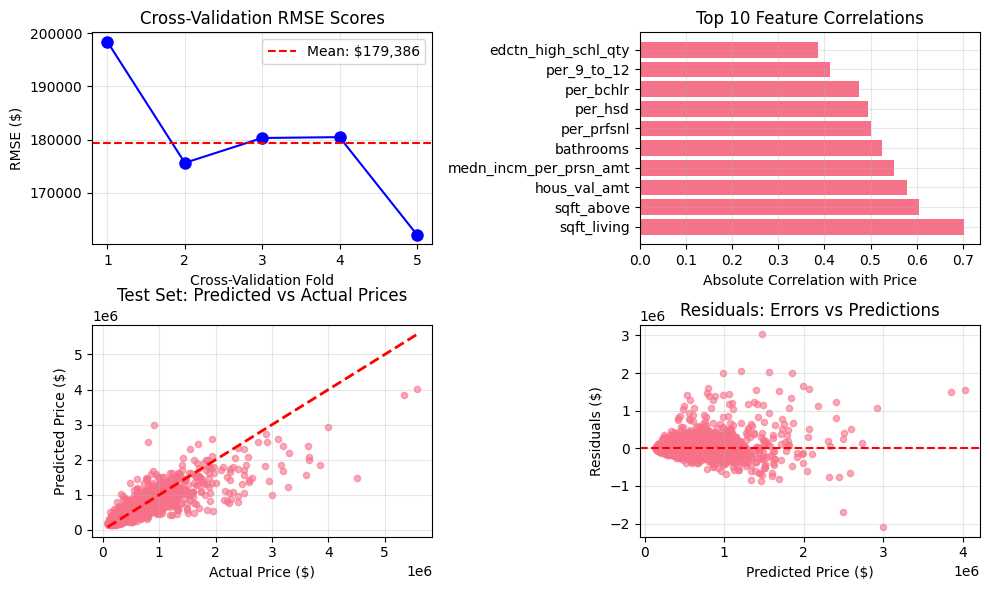

In [9]:
evaluator.generate_visualizations()


## 8. Evaluation Report

Create a human-readable text report summarizing key metrics and assessments. The report is saved to `evaluation_results/evaluation_report.txt` and printed below for convenience.



In [8]:
evaluator.generate_report()
report_path = Path('evaluation_results/evaluation_report.txt')
if report_path.exists():
    with open(report_path, 'r') as f:
        print(f.read())
else:
    print('Report not found at', report_path)




📋 Generating evaluation report...
✅ Report saved to evaluation_results/evaluation_report.txt

HOUSE PRICE PREDICTION MODEL EVALUATION REPORT

MODEL INFORMATION:
------------------------------
Model Type: Pipeline
Features Used: 33
Training Samples: 17290
Test Samples: 4323

CROSS-VALIDATION RESULTS:
------------------------------
Mean RMSE: $179,385.81
Std RMSE: $11,611.58
CV Scores: ['$198,374', '$175,632', '$180,313', '$180,471', '$162,139']

TEST SET PERFORMANCE:
------------------------------
RMSE: $202,626.65
MAE: $102,339.24
R² Score: 0.7284
MAPE: 17.76%

TOP 10 FEATURES BY CORRELATION:
------------------------------
 1. sqft_living         : 0.7020
 2. sqft_above          : 0.6056
 3. hous_val_amt        : 0.5797
 4. medn_incm_per_prsn_amt: 0.5499
 5. bathrooms           : 0.5251
 6. per_prfsnl          : 0.5003
 7. per_hsd             : 0.4944
 8. per_bchlr           : 0.4749
 9. per_9_to_12         : 0.4122
10. edctn_high_schl_qty : 0.3860

GENERALIZATION TEST RESULTS:
------